# MCMC Parameter Fitting

```Code form session 14.2 by prof. Carl Scheffler```

In [1]:
import numpy as np
from scipy import optimize
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import pandas as pd

In [5]:
# Omit the first data point (which includes knowledge of N_0)
url = '''https://gist.githubusercontent.com/raquelhr/d1324510056353feeccf111d6b186a0d/\
raw/7b3bccc7917f3baa7ec1d919195d120083ee75e9/proctatinium_data.csv'''
data = pd.read_csv(url, skiprows=[1])

# Cast data as float, to overcome issues with numerical precision
t_values = np.array(data['time'], dtype=float)
count_values = np.array(data['count_rate'], dtype=float)

data.head()  # Take a quick look at the data

,time,count_rate
0,5,28
1,10,29
2,15,28
3,20,25
4,25,23


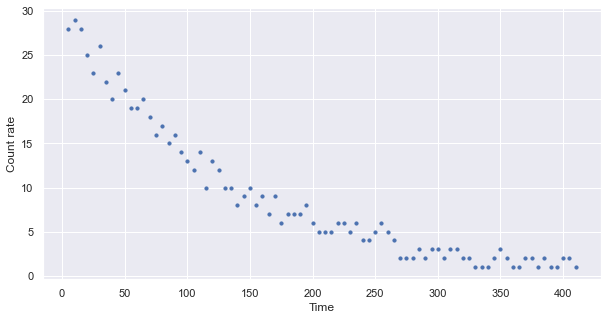

In [8]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.scatter(t_values, count_values, s=10)
plt.xlabel('Time'); plt.ylabel('Count rate')
plt.show()

The steps of the MCMC parameter estimation algorithm are included below. Use these steps to fill in the blanks in the code below.

### MCMC steps

 1. Assume that the maximum likelihood function is obtained by minimising the least squares error:

    $\textrm{likelihood} \sim \exp{(-\chi^2)}$.

    The natural logarithm of this likelihood is already implemented in the function `log_likelihood` below.

In [9]:
def fit_decay(t, theta):
    '''
    The function we are trying to fit to the data, described in Eq. (1) of the
    Study Guide. It is an exponential decay function with parameters theta =
    (N₀, λ).

    Inputs:

      t - The time at which we are counting the number of decayed isotopes.
          theta - The parameters of the function.

    Returns: the number of radioactive isotopes that decayed at time t.
    '''
    return theta[0] * np.exp(-theta[1] * t)


def log_likelihood(t_values, count_values, theta):
    '''
    Compute the natural logarithm of the likelihood function for a given set of
    parameters.

    Inputs:

      t_values_raw, count_values - The data set, containing the time values at
          which we counted the decayed isotopes, and the number of isotopes that
          decayed.
      theta - The parameters of our model, namely N₀ and λ of the exponential
          decay function.
    '''
    fit_values = fit_decay(t_values, theta)
    squared_error = np.sum((fit_values - count_values) ** 2)
    return -squared_error / len(t_values)

In [34]:
theta_guess = np.array([1, 1], dtype=float)  # Notice these are completely off-target!

current_log_likelihood = log_likelihood(t_values, count_values, theta_guess)

mcmc_results = []  # Store the proposals for the parameters in a list
n_trials = 1000000   # Number of trials, or iterations, to be run
np.random.seed(seed=123)  # Set the seed for reproducibility

for i in range(n_trials):
    # Propose new theta using random noise
    new_theta = theta_guess + sts.norm.rvs(0, 1, size=len(theta_guess))

    # Compute the new log likelihood using the new theta value
    new_log_likelihood = log_likelihood(t_values, count_values, new_theta)

    # Compute the likelihood ratio defined in the MCMC algorithm above
    r = np.exp(new_log_likelihood - current_log_likelihood)

    ## Criterion selection
    if np.random.uniform(0, 1) < r:
        theta_guess = new_theta
        current_log_likelihood = new_log_likelihood

    mcmc_results.append(theta_guess)

C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
C:\Users\Taha\Anaconda3\Anaconda4\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  


In [37]:
N0_estimate = np.array(mcmc_results)[:,0]
lambda_estimate = np.array(mcmc_results)[:,1]

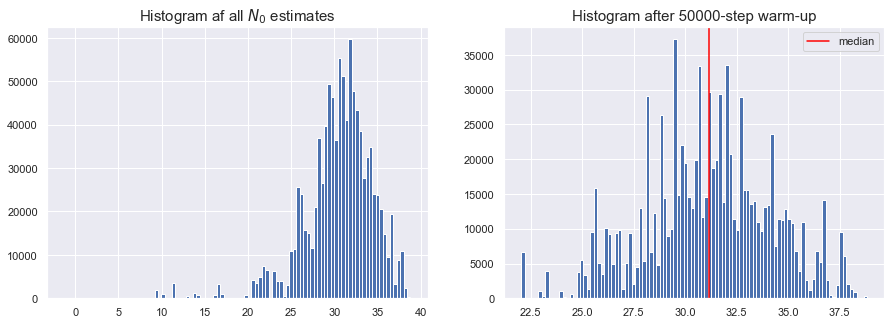

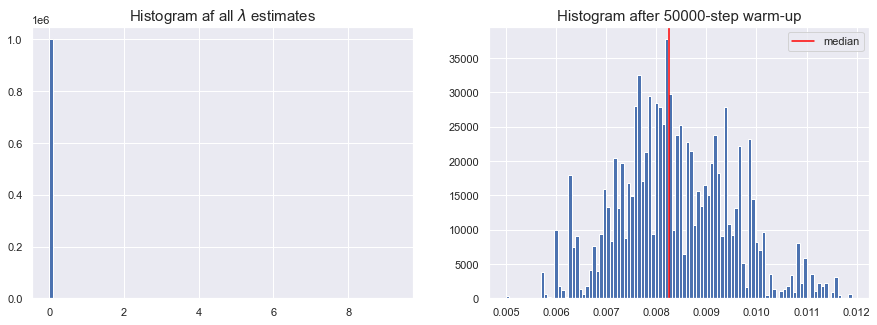

In [41]:
warmup_steps = 50000

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(N0_estimate, bins=100)
plt.title(fr'Histogram af all $N_0$ estimates', fontsize=15)
plt.subplot(1, 2, 2)
plt.hist(N0_estimate[warmup_steps:], bins=100)
plt.axvline(np.median(N0_estimate[warmup_steps:]), color='red', label='median')
plt.legend()
plt.title(fr'Histogram after {warmup_steps}-step warm-up', fontsize=15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(lambda_estimate, bins=100)
plt.title(fr'Histogram af all $\lambda$ estimates', fontsize=15)
plt.subplot(1, 2, 2)
plt.hist(lambda_estimate[warmup_steps:], bins=100)
plt.axvline(np.median(lambda_estimate[warmup_steps:]), color='red', label='median')
plt.legend()
plt.title(fr'Histogram after {warmup_steps}-step warm-up', fontsize=15)

plt.show()

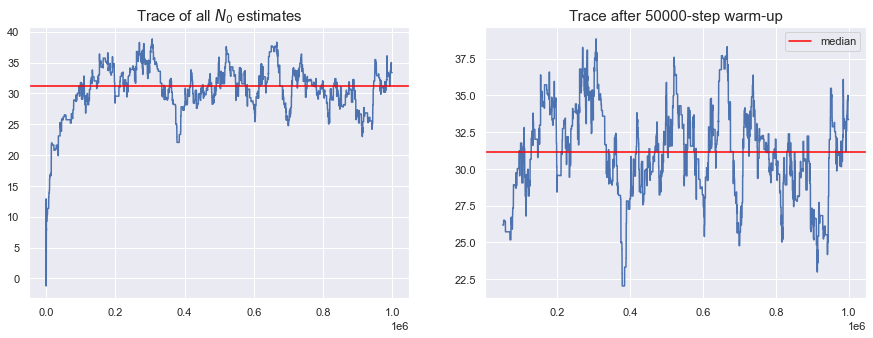

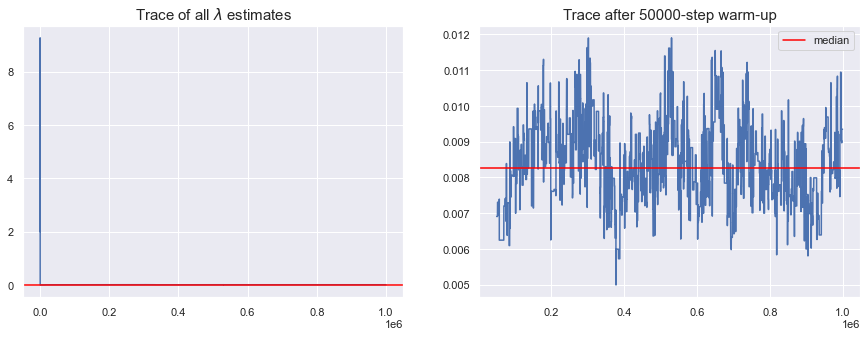

In [42]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(N0_estimate)
plt.axhline(np.median(N0_estimate[warmup_steps:]), color='red')
plt.title(fr'Trace of all $N_0$ estimates', fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(np.arange(warmup_steps, len(N0_estimate)), N0_estimate[warmup_steps:])
plt.axhline(np.median(N0_estimate[warmup_steps:]), color='red', label='median')
plt.legend()
plt.title(fr'Trace after {warmup_steps}-step warm-up', fontsize=15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lambda_estimate)
plt.axhline(np.median(lambda_estimate[warmup_steps:]), color='red')
plt.title(fr'Trace of all $\lambda$ estimates', fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(np.arange(warmup_steps, len(lambda_estimate)), lambda_estimate[warmup_steps:])
plt.axhline(np.median(lambda_estimate[warmup_steps:]), color='red', label='median')
plt.legend()
plt.title(fr'Trace after {warmup_steps}-step warm-up', fontsize=15)
plt.show()

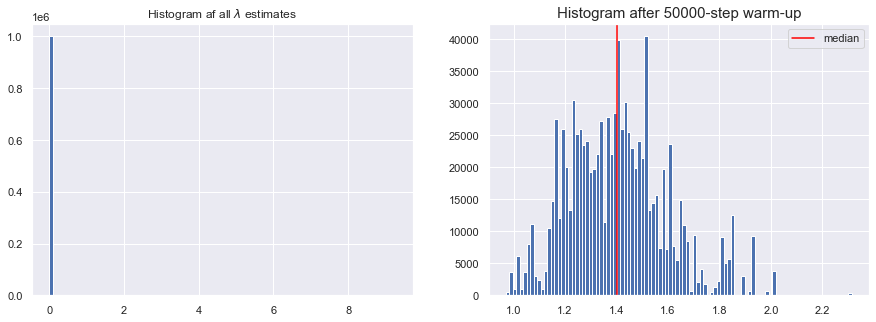

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(lambda_estimate, bins=100)
plt.title(fr'Histogram af all $\lambda$ estimates')
plt.subplot(1, 2, 2)
plt.hist(np.log(2) / lambda_estimate[warmup_steps:] / 60, bins=100)
plt.axvline(np.log(2) / np.median(lambda_estimate[warmup_steps:]) / 60, color='red', label='median')
plt.legend()
plt.title(fr'Histogram after {warmup_steps}-step warm-up', fontsize=15)

plt.show()